In [2]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import geopandas as gpd
%matplotlib inline

import warnings
warnings.simplefilter(action="ignore")

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

import cityImage as ci

### Downloading

Choose between the following methods:
* *OSMplace*, provide an OSM place name (e.g. City).
* *OSMpolygon*, provide an OSM polygon (relation) name.
* *distance_from_address*, provide a precise address and define parameter "distance" (which is otherwise not necessary)

In [3]:
#initialise path, names, etc.
city_name = 'Muenster'
epsg = 25832
crs = {'init': 'epsg:27571', 'no_defs': True}

In [2]:
download_method = 'OSMplace'
distance = None
# downloading
nodes_graph_or, edges_graph_or = ci.get_network_fromOSM(download_method, place, 'walk', epsg, distance = distance)

In [3]:
"""
- "same_uv_edges" regulates the handling of edges with same pair of u-v nodes but different geometries.
When true keeps a center line between the two segments, unless one of the two segments is significantly longer than 
the other (>30%). In this case, the longer segment is deleted.
"""
nodes_graph_or, edges_graph_or = ci.clean_network(nodes_graph_or, edges_graph_or, dead_ends = True, 
                        remove_disconnected_islands = True, self_loops = True, same_uv_edges = True)

In [4]:
# saving
saving_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/'
nodes_graph_or.to_file(saving_path+city_name+'_nodes.shp')
edges_graph_or.to_file(saving_path+city_name+'_edges.shp')

### Alternatively, load cleaned network from local path

In [4]:
loading_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/'
nodes_graph_or = gpd.read_file(loading_path+city_name+'_nodes.shp')
edges_graph_or = gpd.read_file(loading_path+city_name+'_edges.shp')

try:
    nodes_graph_or, edges_graph_or = nodes_graph_or.to_crs(epsg=epsg), edges_graph_or.to_crs(epsg=epsg)
except:
    nodes_graph_or.crs, edges_graph_or.crs = crs, crs
    
    
nodes_graph_or.index, edges_graph_or.index = nodes_graph_or.nodeID, edges_graph_or.edgeID
nodes_graph_or.index.name, edges_graph_or.index.name  = None, None

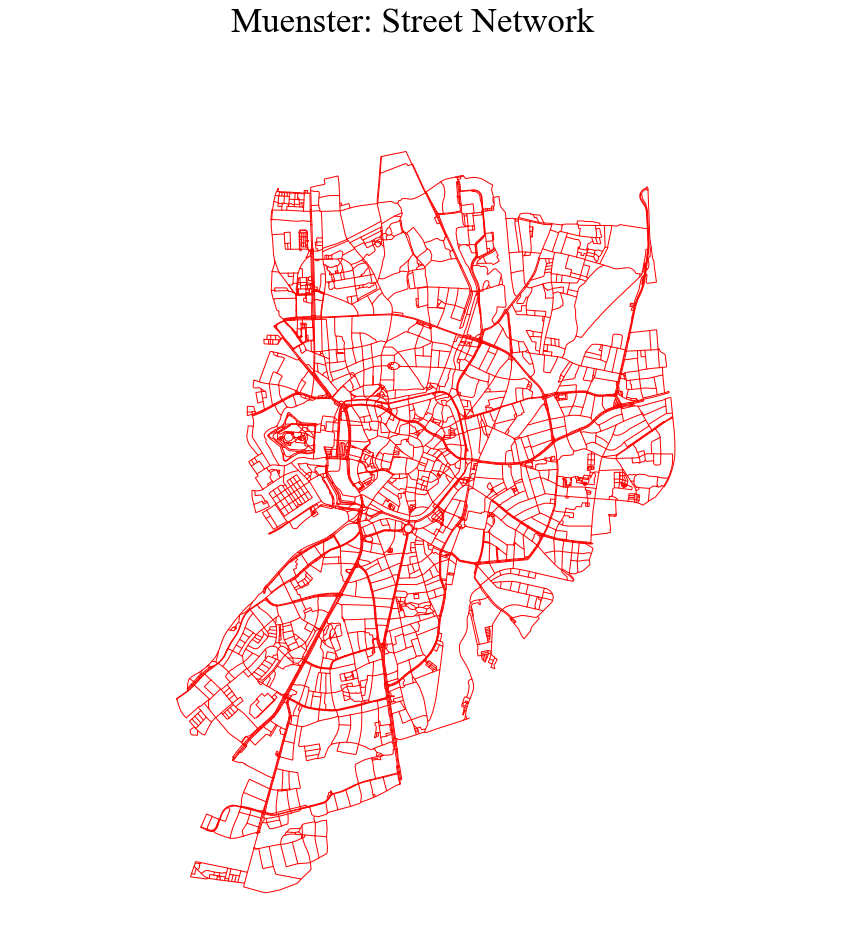

In [6]:
ci.plot_gdf(edges_graph_or, scheme = None,
              black_background = False, fig_size = 15, title = city_name+': Street Network')

# Simplification
## Simplifying junctions

In [7]:
# junctions
nodes_graph, edges_graph = ci.dissolve_roundabouts(nodes_graph_or, edges_graph_or)
nodes_graph, edges_graph = ci.simplify_dual_lines_junctions(nodes_graph, edges_graph)
nodes_graph, edges_graph = ci.simplify_complex_junctions(nodes_graph, edges_graph)

### Extracting centroids from complex junctions to later deal with dual lines

In [8]:
nodes_graph, edges_graph, clusters = ci.identify_clusters(nodes_graph, edges_graph, radius = 12)

## Simplyfing dual lines: cluster-cluster, node-cluster and junctions again

In [9]:
nodes_graph, edges_graph, clusters = ci.simplify_dual_lines(nodes_graph, edges_graph, clusters)
nodes_graph, edges_graph  = ci.simplify_dual_lines_nodes_to_cluster(nodes_graph, edges_graph, clusters)

Simplifying dual lines: First part - clusters
Assigning centroids coordinates
Simplifying dual lines: Second part - nodes
Assigning centroids coordinates


In [10]:
nodes_graph, edges_graph = ci.simplify_dual_lines_junctions(nodes_graph, edges_graph)
nodes_graph, edges_graph = ci.simplify_complex_junctions(nodes_graph, edges_graph)

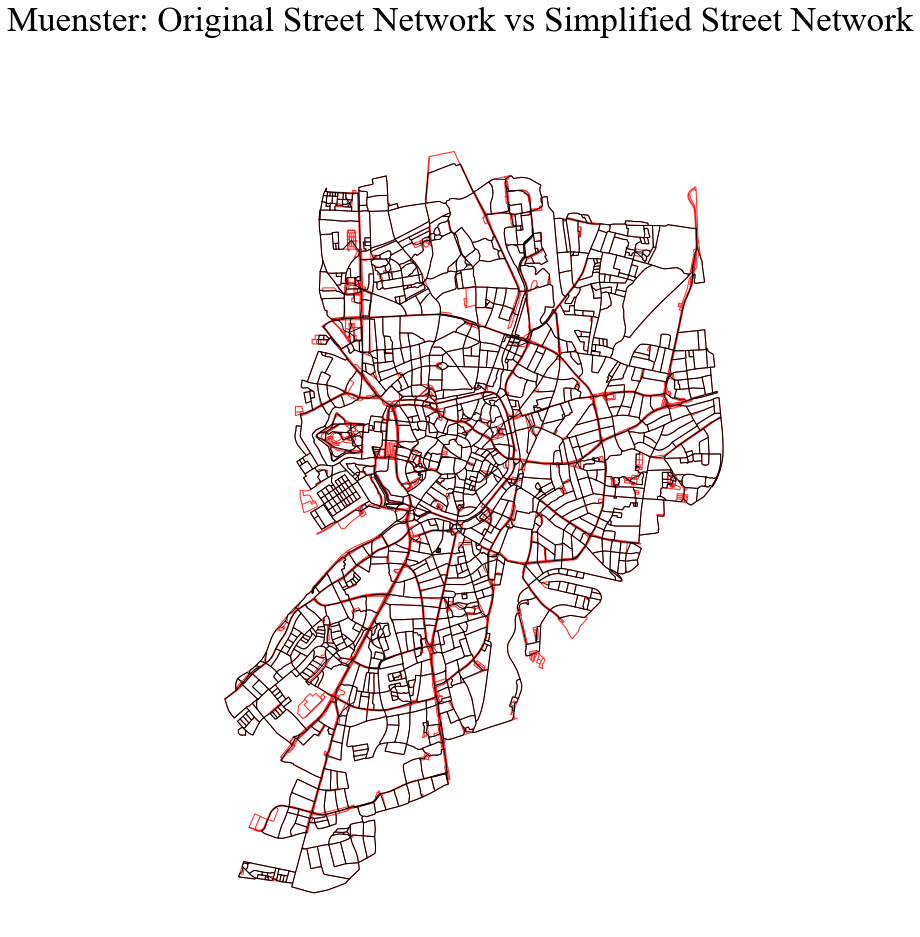

original nr edges:  8914  - Nr edges simplified network:  3509


In [15]:
ci.plot_gdf(edges_graph, scheme = None,  black_background = False, fig_size = 15, color = 'black', title = 
              city_name+': Original Street Network vs Simplified Street Network',
             gdf_base_map = edges_graph_or, base_map_color = 'red', base_map_alpha = 0.8)

print("original nr edges: ", len(edges_graph_or), " - Nr edges simplified network: ", len(edges_graph))

In [19]:
# dual graph
nodesDual_graph, edgesDual_graph = ci.dual_gdf(nodes_graph, edges_graph, epsg)
edges_graph['pedestrian'] *=1
edges_graph['length'] = edges_graph.geometry.length

In [20]:
# saving
saving_path = 'C:/Users/g_filo01/sciebo/Scripts/Image of the City/Outputs/'+city_name+'/'
nodes_graph.to_file(saving_path+city_name+'_nodes_simplified.shp')
edges_graph.to_file(saving_path+city_name+'_edges_simplified.shp')
nodesDual_graph.drop('intersecting', axis = 1).to_file(saving_path+city_name+'_nodesDual_simplified.shp')
edgesDual_graph.to_file(saving_path+city_name+'_edgesDual_simplified.shp')